# fm0

seems like FM0 is a good idea with ASK: transition on every clock cycle, with an extra transition for 0. this is used for other RFID applications.

basic idea: demod. find transitions. find time between transitions. if short short, 0. if long, 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [103]:
n_symb = 32

symb = -1 + 2 * np.random.randint(0, 2, n_symb)

In [104]:
dsymb = np.repeat(symb, 2)
dsymb[1::2] = -1

dsymb = np.insert(dsymb, 0, 1)
dsymb

array([ 1, -1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1, -1,
       -1, -1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1,  1, -1, -1, -1,  1, -1,  1, -1])

In [105]:
cp = np.cumprod(dsymb)
# np.insert(cp, 0, 1)
cp

array([ 1, -1,  1,  1, -1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1,
       -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1,  1,
       -1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1,  1, -1, -1,  1, -1,  1,
       -1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1, -1, -1,  1])

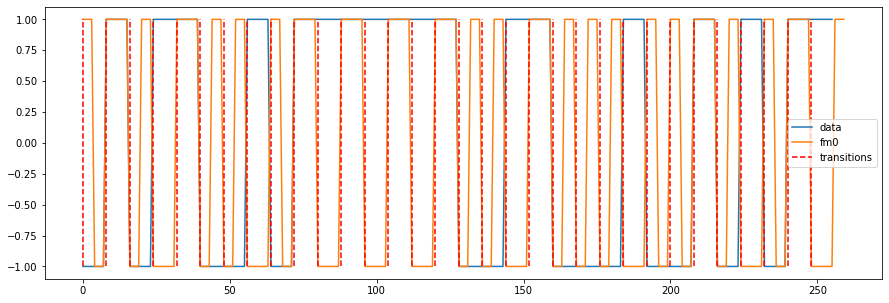

In [106]:
plt.figure(figsize=(15, 5))

plt.plot(np.repeat(symb, 4 * 2))
plt.plot(np.repeat(cp, 4))
plt.vlines(4 * 2 * np.arange(n_symb), -1, 1, linestyle='dashed', color='red')

plt.legend(['data', 'fm0', 'transitions'])



## convert to ask

In [180]:
samp_per_symb = 16
n_samp = n_symb * samp_per_symb + samp_per_symb // 2

ask_symb = np.repeat((cp + 1) // 2, samp_per_symb // 2)

## channel impairments

# noise
n = (np.random.randn(n_samp) + 1j*np.random.randn(n_samp)) / np.sqrt(2)
n_pwr = 0.2
r = ask_symb + n_pwr * n

# frequency offset - this won't change abs
fs = 30e3
fo = 200
Ts = 1 / fs
t = np.arange(0, Ts*len(r), Ts) # time vector
r *= np.exp(1j*2*np.pi*fo*t)

# iq offset
r += (np.random.randn() + 1j * np.random.randn())

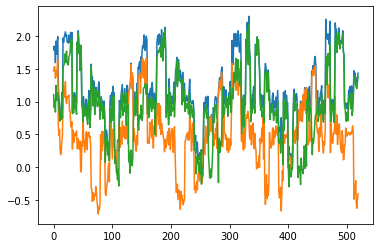

In [181]:
plt.plot(np.abs(r))
plt.plot(np.real(r))
plt.plot(np.imag(r))

## demod!

In [182]:
rx_mag = np.abs(r)

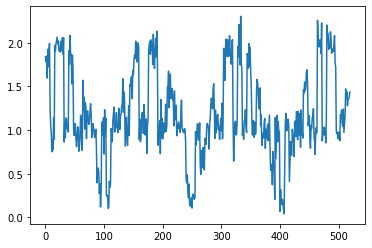

In [183]:
plt.plot(rx_mag)

In [184]:
# remove fixed IQ offset
i_off = np.mean(np.real(r))
q_off = 1j*np.mean(np.imag(r))

print(i_off, q_off)

r_corr = r - i_off - q_off

rx_mag = np.abs(r_corr)

0.48586950567630083 0.934834839313297j


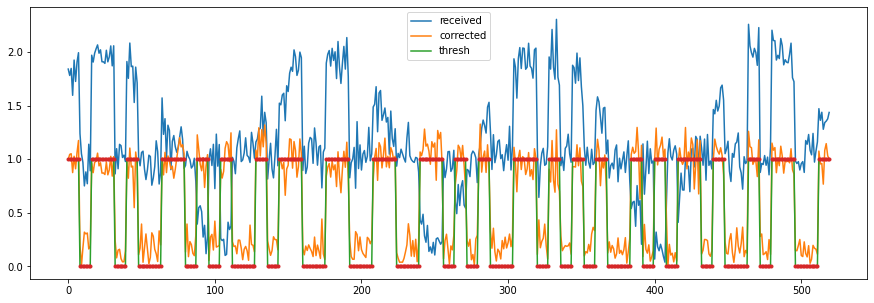

In [185]:
plt.figure(figsize=(15, 5))

plt.plot(np.abs(r))
plt.plot(rx_mag)

r_thresh = np.array(rx_mag > 0.5, dtype=int)

plt.plot(r_thresh)
plt.plot(np.repeat((cp + 1) // 2, 8), '.')

plt.legend(['received', 'corrected', 'thresh']);

In [186]:
# now we have binary samples... reverse fm0
# the short and long pulses will be the two means... proper procedure here would be to treat this as a bimodal
# distribution? but not for now
delta = np.diff(r_thresh)

# add the dummy start-of-frame index... this would eventually be a preamble or smth
delta_idx = np.append([-1], np.where(delta != 0)[0])
pulse_lens = np.diff(delta_idx)

corr_pulse = []

acc = 0

print("original:", pulse_lens)

for p in pulse_lens:
    if p <= 4:
        acc += p
    else:
        if acc > 4:
            print("saw", p, "add", acc)
            corr_pulse.append(acc)
        corr_pulse.append(p)
        acc = 0
    
print(corr_pulse)

short_pulse = 8
long_pulse = 16

original: [ 8  8 16  8  8 16 16  8  8  8  8 16  8  8 16 16 16 16 16 16 16  8  8  8
  8 16 16  8  8  8  8  8  8 16  8  8  8  8 16  8  8 16  8  8 16 16]
[8, 8, 16, 8, 8, 16, 16, 8, 8, 8, 8, 16, 8, 8, 16, 16, 16, 16, 16, 16, 16, 8, 8, 8, 8, 16, 16, 8, 8, 8, 8, 8, 8, 16, 8, 8, 8, 8, 16, 8, 8, 16, 8, 8, 16, 16]


In [187]:
print(corr_pulse)


print(cp)

[8, 8, 16, 8, 8, 16, 16, 8, 8, 8, 8, 16, 8, 8, 16, 16, 16, 16, 16, 16, 16, 8, 8, 8, 8, 16, 16, 8, 8, 8, 8, 8, 8, 16, 8, 8, 8, 8, 16, 8, 8, 16, 8, 8, 16, 16]
[ 1 -1  1  1 -1  1 -1 -1  1  1 -1  1 -1  1 -1 -1  1 -1  1  1 -1 -1  1  1
 -1 -1  1  1 -1 -1  1  1 -1  1 -1  1 -1 -1  1  1 -1  1 -1  1 -1  1 -1 -1
  1 -1  1 -1  1  1 -1  1 -1 -1  1 -1  1  1 -1 -1  1]


In [188]:
# short short is 0. long is 1.
decode_symb = []

mid_pulse = (long_pulse + short_pulse) // 2

while len(pulse_lens):
    # priority is perfect match, then closest
    if all(pulse_lens[:2] == (short_pulse, short_pulse)):
        decode_symb.append(0)
        pulse_lens = pulse_lens[2:]
    elif pulse_lens[0] == long_pulse:
        decode_symb.append(1)
        pulse_lens = pulse_lens[1:]
    else:
        decode_symb.append(0)
        pulse_lens = pulse_lens[2:]
    

In [189]:
symb_bin = (symb + 1) // 2
print(list(symb_bin))
print(decode_symb)

[0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1]
[0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1]


In [190]:
# for some reason we are losing first bit. tbd
100 * np.mean(symb_bin == decode_symb[:len(symb_bin)])

100.0

In [164]:
pulse_lens

array([], dtype=int64)